Here we will perform image segmentation in a method according to this paper: https://www.notion.so/Master-s-Thesis-f4198941092e4564b0ab388bf92c8a56#085d8dd355a9481ea3ed3b8743797baa.

Import image and work out which channel we should use. Pick image with widest distributed historgram.

I wonder if you could do something clever with PCA to choose a linear combination of RGB which maximises variance. Another time perhaps

(520, 520, 3)


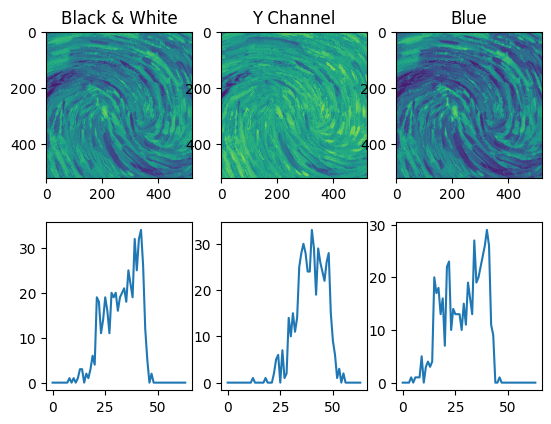

In [139]:
import cv2
import scipy.stats.qmc as qmc
import matplotlib.pyplot as plt 
import numpy as np

random_seed = 0

im = cv2.imread('../res/starry_night_crop.jpg')
im_Y = cv2.cvtColor(im, cv2.COLOR_BGR2YCR_CB)
im_Y = im[:,:,0]
im_bw = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
im_B = im[:,:,2]
print(im.shape)
plt.subplot(2,3,1)
plt.title("Black & White")
plt.imshow(im_bw)
plt.subplot(2,3,2)
plt.title("Y Channel")
plt.imshow(im_Y)
plt.subplot(2,3,3)
plt.title("Blue")
plt.imshow(im_B)
plt.subplot(2,3,4)
plt.plot(cv2.calcHist(im_bw, [0], None,[64],[0,256]))
plt.subplot(2,3,5)
plt.plot(cv2.calcHist(im_Y, [0], None,[64],[0,256]))
plt.subplot(2,3,6)
plt.plot(cv2.calcHist(im_B, [0], None,[64],[0,256]))


Let's actually try the PCA thing...

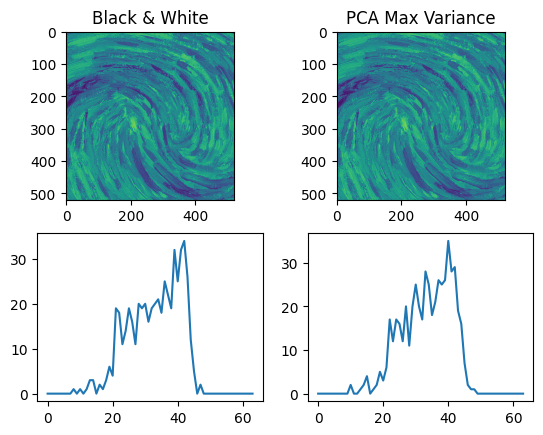

In [140]:
#First let's try to do a covariance matrix 😬
im_r = im[:,:,2]
im_g = im[:,:,1]
im_b = im[:,:,0]

#Reshape them into vectors, rather than matrices
im_r_flat = np.reshape(im_r, [1,np.size(im_r)])
im_g_flat = np.reshape(im_g, [1,np.size(im_r)])
im_b_flat = np.reshape(im_b, [1,np.size(im_r)])

#Subtract mean
im_r_flat = im_r_flat - np.mean(im_r_flat)
im_g_flat = im_g_flat - np.mean(im_g_flat)
im_b_flat = im_b_flat - np.mean(im_b_flat)

#Create covariance matrix
im_stacked = np.vstack((im_r_flat,im_g_flat, im_b_flat))
cov = im_stacked @ im_stacked.T

[W,V] = np.linalg.eig(cov)
mx_eig = np.argmax(W)
v = V[:,mx_eig]


im_maxvar = np.uint8((im_r*v[0]+im_g*v[1]+im_b*v[2])/np.sum(v))
plt.subplot(2,2,1)
plt.title("Black & White")
plt.imshow(im_bw)
plt.subplot(2,2,2)
plt.title("PCA Max Variance")
plt.imshow(im_maxvar)
plt.subplot(2,2,3)
plt.plot(cv2.calcHist(im_bw, [0], None,[64],[0,256]))
plt.subplot(2,2,4)
plt.plot(cv2.calcHist(im_maxvar, [0], None,[64],[0,256]))

Incredible - that was almost completely pointless

1. Initialise seed points

The paper referenced uses the sobol algorithm, so we will use that too for now. 

How many points do we need? I have no idea, but the crop is 520x520 px, so why not something like 1024 to start. We can evaluate this later.

Text(0.5, 1.0, 'Seed locations')

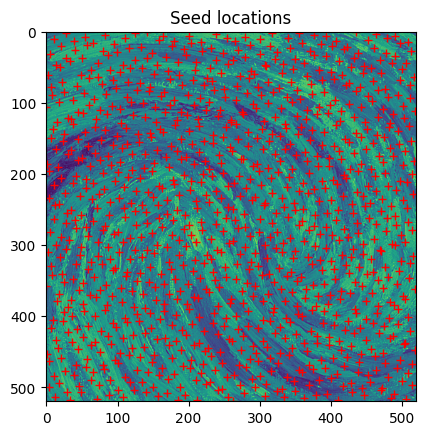

In [141]:
n_points = 10 #Nb this is log_10(number of actual points)
generator = qmc.Sobol(2,bits=n_points, seed = random_seed)
seeds = np.uint64(generator.random_base2(m=n_points)*520)
plt.imshow(im_maxvar)
plt.plot(seeds[:,0], seeds[:,1], 'r+')
plt.title('Seed locations')


2. For each seed, flood fill up to a threshold level T.
3. If the area is too large, reduct T.
4. Perform region closure on the brushstroke

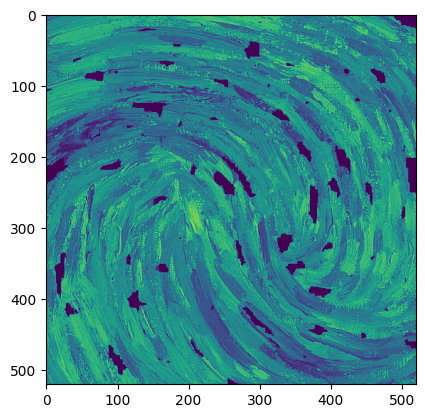

In [188]:
T=100
im_out = im_maxvar.copy()
brush_options_list = []
region_size_list = []
for seed_index in range(seeds.shape[0]):
    t = T 
    region = cv2.floodFill(im_maxvar, None, seeds[seed_index], 1, t, t, cv2.FLOODFILL_MASK_ONLY)[2]

    while np.sum(region) > 2500 and t > 0:
        #3
        t -= 2
        #2
        region = cv2.floodFill(im_maxvar, None, seeds[seed_index], 0, t, t, cv2.FLOODFILL_MASK_ONLY)[2]
    region = region[1:-1,1:-1]
    #4
    region = cv2.morphologyEx(region, cv2.MORPH_CLOSE, np.ones([20,20]))
    im_out = im_out * (1-region)
    brush_options_list.append(region)
    region_size_list.append(np.sum(region))

plt.imshow(im_out)

4.5 Select for larger brush strokes

5. Reject brush stroke if it is strange


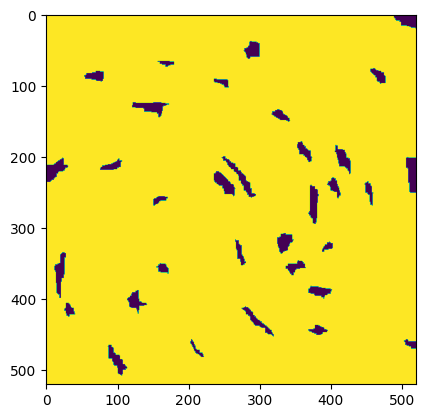

In [193]:
existing_image = np.ones(im_maxvar.shape)


brushstrokes = []
brushtroke_size_list = np.argsort(region_size_list)
brushtroke_size_list = np.flip(brushtroke_size_list)
sz = np.size(brushtroke_size_list)

#4.5
for i in range(sz):
    region_index = brushtroke_size_list[i]
    if np.sum(existing_image*brush_options_list[region_index]) == region_size_list[region_index]:
        #5
        if (region_size_list[region_index] < 100):
            break

        brushstrokes.append(brush_options_list[region_index])
        existing_image = existing_image*(1-brush_options_list[region_index])
plt.imshow(existing_image)

Now we want to extract a vector field. Do this by fitting an x-y line to each brushstroke, assigning vectors in that brushstroke to the direction of that x-y line.

In [203]:
a = np.ones([im_maxvar.shape[0],1])
b = np.array([range(im_maxvar.shape[1])])
x_ordinates = np.reshape(a @ b, np.size(im_maxvar))
a = np.array([range(im_maxvar.shape[1])]).T
b = np.ones([im_maxvar.shape[0],1]).T
y_ordinates =  np.reshape(a @ b, np.size(im_maxvar))

for r in range(len(brushstrokes)):
    selected_x = x_ordinates[np.reshape(brushstrokes[r], np.size(im_maxvar))]
    selected_y = y_ordinates[np.reshape(brushstrokes[r], np.size(im_maxvar))]
    print(selected_x.shape)
    print(selected_y.shape)
    selected_x = np.hstack((selected_x, np.ones([np.size(im_maxvar),1])))
    
    m = np.invert(selected_x.T@selected_x)*(selected_x.T@selected_y)


(270400,)
(270400,)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)